<span style="font-size: 30px;">**Chat with Your Documents Using GPT & LangChain**</span>


**Objectives:** 
- *Learn how to effectively load & store documents using LangChain*
- *Build a retrieval augmented generation pipeline for querying data*
- *Build a question-answering bot that answers questions based on your documents*

You can learn more about the LangChain library in the following links:
* [How to Make Large Language Models Play Nice with Your Software Using LangChain](https://www.kdnuggets.com/how-to-make-large-language-models-play-nice-with-your-software-using-langchain)
* [6 Problems of LLMs That LangChain is Trying to Assess](https://www.kdnuggets.com/6-problems-of-llms-that-langchain-is-trying-to-assess)

Let's start by understanding our main goal:

First: 
- Take a set of PDFs. 
- Break them into pieces of texts. 
- Embed them into a vectorized representation. 
- Store them into a vector database. (FAISS, CHROMA, PINECONE...)
- Once the vectors are persistend in the ddbb, we can get queries, embed them and find a similar chunk vectors. 
- The chunks are ranked according to how relevant they are to the question and are used to contextualize our LLM. 

**IMPORTANT:** The LLM doesn't really know what PDFs have. We take advantage of the LLM model to generate NLP answers and provide it with a question and a context to generate an accurate answer. 

![Structure_main](Structure_main.png)

# Install Imports and API Keys

We need to make sure our environment has the following packages: 

- Create a conda enviroment for compatibillity between packages; 
- Install `langchain` 
- Install `tiktoken`, `wikipedia`, `pypdf`, `faiss-cpu`, `pinecone-client`.

In [ ]:
#!conda create -n conda_llm python==3.8.10
!conda init
!conda activate conda_llm

In [ ]:
%pip install httpx==0.27.2
%pip install openai==1.55.3
%pip install langchain==0.2.11
%pip install langchain-openai==0.1.19
%pip install langchain-community==0.2.10
%pip install langchain-experimental==0.0.63
%pip install tiktoken==0.7.0
%pip install wikipedia==1.4.0
%pip install pypdf==4.1.0
%pip install faiss-cpu==1.7.4
%pip install pinecone-client==3.1.0
%pip install pandas==1.5.1
%pip install matplotlib==3.6.3
%pip install python-dotenv==1.0.0
%pip install sentence-transformers==2.2.2
%pip install pandas
%pip install matplotlib
%pip install matplotlib-inline


Before starting, make sure you have avaiable: 
- OpenAI API Key
- Pinecone API Key and environment. 

To get our API keys, we can set them in an .env document and load them into our environement using the 'load_dotenv()' command or define them directly. 
- To obtain OpenAI API Keys, you can follow the instructions [here](https://medium.com/forcodesake/a-step-by-step-guide-to-getting-your-api-key-2f6ee1d3e197). 
- To obtain Pinecone API keys, you can follow the instructions [here](https://medium.com/forcodesake/pinecone-api-chatgpt-artificial-intelligence-4332de128dd5). 

In [2]:
# Basics
import os
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv

# LangChain Training
# LLM
from langchain.llms import OpenAI

# Document Loader
from langchain.document_loaders import PyPDFLoader 

# Splitter
from langchain.text_splitter import RecursiveCharacterTextSplitter 

# Tokenizer
from transformers import GPT2TokenizerFast  

# Embedding
from langchain.embeddings import OpenAIEmbeddings 

# Vector DataBase
from langchain.vectorstores import FAISS, Pinecone # for the vector database part -- FAISS is local and temporal, Pinecone is cloud-based and permanent. 

# Chains
#from langchain.chains.question_answering import load_qa_chain
#from langchain.chains import ConversationalRetrievalChain

In [3]:
# We can directly upload our keys using a .env
load_dotenv()

import os

openai_api_key = os.environ["OPENAI_API_KEY"]
pinecone_api_key = os.environ["PINECONE_API_KEY"]
pinecone_env_key = os.environ["PINECONE_ENV_KEY"]

# Alternatively, you can set the API keys as follows:
#OPENAI_API_KEY   = "sk-"
#PINECONE_API_KEY = "34..."
#PINECONE_ENV_KEY = "gcp-starter"


# PART 1: LANGCHAIN BASICS


🎯 **Objective:** Understand what is the LangChain library and all the elements that are required to generate a simple pipeline to query out documents. 

### **What is LangChain?**
> LangChain is a framework for developing applications powered by language models.

LangChain makes the hardest parts of working with AI models easier in two main ways:

1. **Data-aware** - Bring external data, such as your files, other applications, and API data, to your LLMs
2. **Agentic** - Allow your LLMs to interact with it's environment via decision making. Use LLMs to help decide which action to take next. 

### **Why LangChain?**
1. **Components** - Abstractions for working with language models, along with a collection of implementations for each abstraction. Components are modular and easy-to-use, whether you are using the rest of the LangChain framework or not

2. **Chains** - LangChain provides out of the box support for using and customizing 'chains' - a series of actions strung together. A structured assembly of components for accomplishing specific higher-level tasks.

3. **Speed 🚢** - This team ships insanely fast. You'll be up to date with the latest LLM features.

4. **Community 👥** - Wonderful discord and community support, meet ups, hackathons, etc.

Though the usage of LLMs can be straightforward (text-in, text-out), when trying to build complex applications you'll quickly notice friction points. 

> LangChain helps with once you develop more complicated application and manage LLMs the way we want. 

## LangChain Components

The LangChain library contains multiple elements to ease the process of building complex applications using LangChain.
In this module we will focus mainly in 10 elements:

**To load and process our documents**
- Document Loaders
- Text Splitters
- Chat Messages *(Optional)*


**To talk with our documents using NLP**
- LLM model (GPT, Llama...)
- Chains
- Natural Language Retrieval
- Metadata and Indexes
- Memory *(Optional)*

**Both Processes**
- Text Embedding (OpenAI or Open-source models)
- Vector Stores 

![Structure_basics](Structure_basics.png)


###  **The Model - Large Language Model of our choice**
An AI-powered LLM that takes text in and responses text out. 
The default model is always ada-001, but we can explicitly choose the model of our preference. 

You can check the list of all avaialble models [here](https://platform.openai.com/docs/models)

In [4]:
import os
from openai import OpenAI

client = OpenAI(
    # This is the default and can be omitted
    api_key=os.environ.get("OPENAI_API_KEY"), #you can put the key here directy
)

chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "Please, tell me some funny jokes",
        }
    ],
    model="gpt-3.5-turbo",
)

Sure, here are a few jokes for you:

1. Why don't scientists trust atoms? Because they make up everything!

2. Why don't skeletons fight each other? They don't have the guts!

3. What do you call a bear with no teeth? A gummy bear!

4. Why don't eggs tell jokes? Because they might crack up!

5. Why did the scarecrow win an award? Because he was outstanding in his field!

6. What do you call a fish wearing a crown? King Neptune!

7. Why did the bicycle fall over? Because it was two-tired!

8. How do you organize a space party? You "planet"!

9. Why don't scientists trust stairs? Because they're always up to something!

10. What do you call a snowman with a six-pack? An abdominal snowman!

Remember, humor is subjective, so what may be funny to one person may not be to another. Enjoy!


In [ ]:
chat_completion

In [ ]:
output = chat_completion.choices[0].message.content
print(output)

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.agents import create_openai_tools_agent, AgentExecutor
from langchain.tools import tool
from langchain_core.messages import HumanMessage, AIMessage

@tool
def multiply(a, b):
    "Multiply to numbers. For any questions about multiplying two numbers, you must use this tool!"
    return a * b

llm = ChatOpenAI()
tools = [multiply]

prompt = ChatPromptTemplate.from_messages([
  ("system", "You are a helpful assistant"),
  MessagesPlaceholder(variable_name="chat_history", optional=True),
  ("human", "{input}"),
  MessagesPlaceholder(variable_name="agent_scratchpad")
])

chat_history = [HumanMessage(content="Do you know what is 5 times 6?"), AIMessage(content="Yes!")]
agent = create_openai_tools_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools)
response = agent_executor.invoke({"input": "tell me", "chat_history": chat_history})    # the question itself is based on prior history
print(response["output"])        # 5 times 6 is 30.


### **Chat Messages**
LangChain allows us to segmentate prompts into three main types.(System, Human, AI)

* **System** - Helpful background context that tell the AI its high-level behavior.
* **Human** - Messages that represent the user input. 
* **AI** - Messages that show the response of the AI model, they work as examples to the model. 


For more, see OpenAI's [documentation](https://platform.openai.com/docs/guides/chat/introduction)

In [5]:
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage, SystemMessage, AIMessage

chatgpt = ChatOpenAI(model_name = "gpt-3.5-turbo",
                  temperature=0
                 )

high_level_behavior = """
                       You are an AI bot that help people decide where to travel. 
                       Always recommend three destination with a short sentence for each.
                      """

response = chatgpt.invoke(
    [
        SystemMessage(content=high_level_behavior),
        AIMessage(content="Hello! I am a traveller assistant, how can I help you?"),
        HumanMessage(content="Where should I travel next?"),
    ]
)

print(response.content)

That depends on your preferences! Could you please let me know what type of destination you are looking for? For example, do you prefer beach destinations, historical cities, or natural landscapes?


You can also pass more chat history with responses from the AI

In [6]:
response = chatgpt(
        [
            SystemMessage(content=high_level_behavior),
            AIMessage(content="Hello! I am a traveller assistant, how can I help you?"),
            HumanMessage(content="Where should I travel next?"),
            SystemMessage(content="What do you enjoy doing?"),
            HumanMessage(content="I love going to Museums?"),
        ]
    )

print(response.content)

Based on your love for museums, here are three destinations you might enjoy:

1. Paris, France: Known as the "City of Museums," Paris is home to world-renowned museums like the Louvre, Musée d'Orsay, and Centre Pompidou, offering a rich collection of art, history, and culture.

2. Florence, Italy: Florence is a treasure trove of art and history, with museums like the Uffizi Gallery and Accademia Gallery housing masterpieces by Michelangelo, Botticelli, and more, making it a haven for art enthusiasts.

3. St. Petersburg, Russia: St. Petersburg boasts the Hermitage Museum, one of the largest and most prestigious art museums in the world, showcasing a vast collection of art and cultural artifacts from around the globe.


### **Text Embedding Model**

When documents or string-variables are too long, things got quite complicated. 

**In order to be able to process them, we can embed and convert string variables into vectors** (a series of numbers that hold the semantic 'meaning' of your text).

Mainly used when comparing different pieces of text or when dealing with huge texts. 

**TASK:**
- First import the `Embeddings` model from langcgain.embeddings.
- Define a text to embed. 
- Embed the text with the `.embed_query` command. 

In [7]:
# 1. Import the embedding model
# from langchain.embeddings import OpenAIEmbeddings
from langchain_openai import OpenAIEmbeddings

# 2. Create an instance of the model
embeddings = OpenAIEmbeddings()

# 3. Define a text to embed
text = "Hi! It's time to go to a Museum!"

# 4. Embed the text
text_embedding = embeddings.embed_query(text)
print (f"Your embedding is length {len(text_embedding)}")
print (f"Here's a sample: {text_embedding[:5]}...")

Your embedding is length 1536
Here's a sample: [0.009987601079046726, -0.014433100819587708, 0.010184594430029392, -0.0038019861094653606, -0.01780826598405838]...


### **Chains**

Conversation chains in the context of Langchain are a concept involving the sequential linking of multiple conversational elements to build complex interactions. The idea is to streamline and enhance the conversation flow.

The most basic chain is the `ConversationChain`. However, we will use the `load_qa_chain` to query questions about our documents, as its main function is optimized for this task. 

You can go check all available chains in the [LangChain Documentation.](https://python.langchain.com/docs/modules/chains/)

In [8]:
from langchain.chains import ConversationChain

conversation = ConversationChain(llm=chatgpt)
conversation.run("Hello!")

#from langchain.chains.question_answering import load_qa_chain 

#chain = load_qa_chain(chatgpt, chain_type="stuff")
#chain.run(input_documents = matches, question = enriched_query)

'Hello! How can I assist you today?'

### Memory
When interacting with a model, it is important to keep track of all interactions performed with it. 

To overcome these limitations, langchain implements different types of memories to use in your application.

It is important to consider that storing all the interactions with the model can quickly escalate to a considerable amount of tokens to process every time we prompt the model. It is essential to bear in mind that ChatGPT has a token limit per interaction.

You can learn more about memory [here]([https://towardsdatascience.com/custom-memory-for-chatgpt-api-artificial-intelligence-python-722d627d4d6d])



In [9]:
from langchain.memory import ConversationSummaryBufferMemory

memory = ConversationSummaryBufferMemory(llm=chatgpt, max_token_limit=100)

memory.save_context({"input":  "Can you recommend me where should I travel next?"}, 
                    {"output": "Hello! I am a traveller assistant, sure I can help you. What do you enjoy doing?"})

memory.save_context({"input":  "I love going to Museums"}, 
                    {"output": "Great then you should go to a cultural capital."})

chatgpt = ChatOpenAI(model_name = "gpt-3.5-turbo",
                  temperature=0
                 )

conversation = ConversationChain(
    llm=chatgpt, 
    memory = memory,
    verbose=True
)

conversation.run("What cities do you recommend me?")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: Can you recommend me where should I travel next?
AI: Hello! I am a traveller assistant, sure I can help you. What do you enjoy doing?
Human: I love going to Museums
AI: Great then you should go to a cultural capital.
Human: What cities do you recommend me?
AI:

> Finished chain.


"There are many cities around the world that are known for their rich cultural heritage and numerous museums. Some popular options include Paris, France, which is home to the Louvre Museum and the Musée d'Orsay; London, England, where you can visit the British Museum and the Tate Modern; and New York City, USA, which boasts the Metropolitan Museum of Art and the Museum of Modern Art. These cities offer a wide range of museums and cultural experiences for you to explore."

### Dealing with Documents

We are here to deal with documents... so LangChain provides a wide variety of elements to deal with them. 

One of the most important improvements of LangChain is that it allows us to upload documents and pass them to our model. 
We consider a document as an object that holds a piece of text and metadata (more information about that text)

- Document class
- Document Loader
- Document Retriever
- Text Splitter
- Index

**TASK**

1. From langchain.schema import the `Document` class. 
2. Now define a document that has 
   - Text contained in page_content. 
   - Metada composed of document_id, document_source and document_create_time. 

In [10]:
# 1. Import the document class
from langchain.schema import Document

# 2. Define the document:
Document(
         page_content="This is a dummy document",
         metadata={
             #
             #
             #
                   }
                   )

Document(page_content='This is a dummy document', metadata={'document_id': 677, 'document_source': 'mysource.pdf', 'document_create_time': '01/06/2022'})

#### Document Loaders

Depending on where our data is stored, we will need a different type of loader:

- The **Online Loader** is used for loading a document directly from the Internet. LangChain implements different types of loaders. For example, there is the `WikipediaLoader` that helps you loading Wikipedia pages or the `HNLoader` to take content directly from any HackerNews page.



- The **Offline Loader** is used loading a document stored that are already installed in your machine. There are also different types of offline loaders such as the **HTML** loader for `.html` pages or the **PyPDFLoader** for `.pdf` documents.

In this tutorial, we will see an example of Online Loader by using the `WikipediaLoader` and the `HNLoader`, and an example of Offline Loader by using the PyPDFLoader.

You can find a list of the supported [LangChain Document Loaders](https://python.langchain.com/docs/integrations/document_loaders) in the official documentation. Those Loaders are from external integrations, [native LangChain Loaders](https://python.langchain.com/docs/modules/data_connection/document_loaders/) can be found in the official documentation as well.

In [11]:
from langchain.document_loaders import WikipediaLoader
 
# Load content from Wikipedia using WikipediaLoader
loader = WikipediaLoader("Machine_learning")
wikipedia_data = loader.load() #It returns a list of documents

wikipedia_data[0]

Document(page_content='Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. Recently, generative artificial neural networks have been able to surpass many previous approaches in performance.Machine learning approaches have been applied to large language models, computer vision, speech recognition, email filtering, agriculture, and medicine, where it is too costly to develop algorithms to perform the needed tasks. ML is known in its application across business problems under the name predictive analytics. Although not all machine learning is statistically based, computational statistics is an important source of the field\'s methods.\nThe mathematical foundations of ML are provided by mathematical optimization (mathematical programming) methods. Data mining is a related (parallel) field of study, 

In [12]:
print("\nPage Content: \n", wikipedia_data[0].page_content)
print("\nMeta Data: \n", wikipedia_data[0].metadata)


Page Content: 
 Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. Recently, generative artificial neural networks have been able to surpass many previous approaches in performance.Machine learning approaches have been applied to large language models, computer vision, speech recognition, email filtering, agriculture, and medicine, where it is too costly to develop algorithms to perform the needed tasks. ML is known in its application across business problems under the name predictive analytics. Although not all machine learning is statistically based, computational statistics is an important source of the field's methods.
The mathematical foundations of ML are provided by mathematical optimization (mathematical programming) methods. Data mining is a related (parallel) field of study, focusing

**TASK:**

Repeat the previous procedure using `HNLoader` and `PyPDFLoader`. 
1. Import the corresponding Loader from langchain.document_loaders. 
2. Initialize the loader indicating the source of data. 
    - HNLoader -> https://news.ycombinator.com/item?id=34422627
    - PyPDFLoader -> Docs/attentions.pdf
    - PyPDFDirectoryLoader -> Docs/

In [13]:
# Online Loader
from langchain.document_loaders import HNLoader
# loader = 
# hn_data = 

# Load content from local PDFs

#We can use a directory loader to load more than one PDF at once. 
#loader = PyPDFDirectoryLoader("Docs/")
#pdf_directory_data = loader.load()

#### Text Splitter

**Data Chunks and Model Tokenizer**

To efficiently handle data when building an LLM-based application, data needs to be divided in portions. Those are the so-called data chunks and the chunk size is highly determinant in the quality of the chatbot.

The tokenizer plays a crucial role in relation to data chunks when working with LLMs: 
- A **tokenizer is the tool used to convert text data into a format that can be processed by the model.**
- Data is then stored in the vector stores in the tokenized format.

To convert the original data into tokens and split it in data chunks, we will use the **LangChain Text Splitter**.

If you are interested in more details about the tokenizer, the article [Unleashing the ChatGPT Tokenizer](https://medium.com/towards-data-science/chatgpt-tokenizer-chatgpt3-chatgpt4-artificial-intelligence-python-ai-27f78906ea54) is for you!


By using Langchain, we can highly customize how to split our data:
- **Split by chunks**: The most general approach is to split your data into chunks of a concrete size. In the following example, we will take the data that we have already loaded (`wikipedia_data`, `hn_data` and `pdf_data`) and we will split it in portions of 200 characters. 

_What will happen if the split based on character count breaks a word?_

There is the concept of "chunk overlap" that refers to a method where consecutive chunks of text share some common content. This technique is used to maintain context and coherence when a long document is divided into smaller parts due to the token limitations of LLMs. In this case, we will use a chunk size of 20 characters.

So let's split the Wikipedia data we have just loaded: 

In [14]:
# Splitter
from langchain.text_splitter import RecursiveCharacterTextSplitter 

# Tokenizer
from transformers import GPT2TokenizerFast  

# Advanced method - Split by chunks ________________________________________________________________________
# Create function to count tokens
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def count_tokens(text: str) -> int:
    return len(tokenizer.encode(text))

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size      = 200, 
    chunk_overlap   = 20,
    length_function = count_tokens # It uses len() by default. 
)

print("\nSPLITTING BY CHUNKS")
wikipedia_chunks = text_splitter.split_documents(wikipedia_data)
print("Wikipedia Data - Now you have {0} number of chunks.".format(len(wikipedia_chunks)))


SPLITTING BY CHUNKS
Wikipedia Data - Now you have 78 number of chunks.


**TASK:**

Generate the chunks for both `HNLoader` and `PyPDFLoader`. 
1. Import both RecursiveCharacterTextSplitter from langchain.text_splitter and GPT2TokenizerFast from transformers. 
2. Define a tokenizer with the following command: tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
3. Define a count_tokens function that will allow us to count the tokens of out text. 
4. Define the text_splitter with a chunk_size of 200, a chunk_overlap of 20 and the length_function we have just defined. 
5. Apply the command `.split_documents`to our data. 

You can define your own function for the HN data and use your the default function for the PDF Data.  

In [15]:
#_____________________________________________________________________PDF DATA
# 1 - Splitter
from langchain.text_splitter import RecursiveCharacterTextSplitter 
# 2 - Tokenizer
 
# 3 - Create function to count tokens

# 4 - Define the splitter
# text_splitter = ____( )


# 5 - Apply the .split_document command
# pdf_chunks = text_splitter.
# print("PDF Data - Now you have {0} number of chunks."_________))


# HN DATA
# 3 - We use the default len, no need to do anything.

# 4 - Define the splitter



PDF Data - Now you have 64 number of chunks.
Online HN - Now you have 232 number of chunks.


We can make sure that the chunking has been successful by visualizing the distribution of chunk sizes. 
Since we have selected a chunk size of 200, the majority of our chunks should have this lenght:

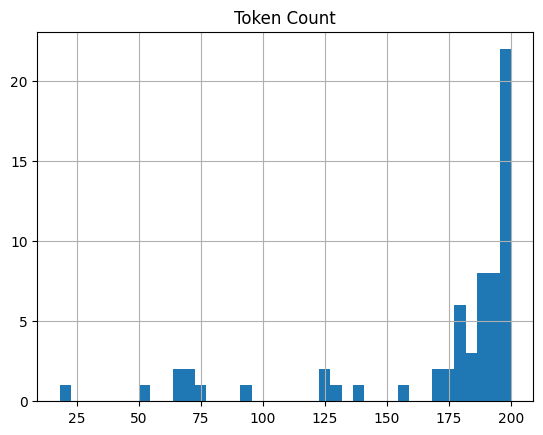

In [16]:
# Quick data visualization to ensure chunking was successful

# Create a list of token counts
token_counts = [count_tokens(chunk.page_content) for chunk in pdf_chunks]

# Create a DataFrame from the token counts
df = pd.DataFrame({'Token Count': token_counts})

# Create a histogram of the token count distribution
df.hist(bins=40, )

# Show the plot
plt.show()

- **Split by pages**: If your data comes from documents organized in pages, there are methods that allow you to split data in pages to keep track of the page content. This method is specially useful when dealing with PDFs, as in the following example:

In [51]:
# Simple method - Split by pages    ________________________________________________________________________
# You need a PDF file in your environement. 
loader = PyPDFLoader("Docs/attentions.pdf")
pdf_pages_chunks = loader.load_and_split()
pdf_pages_chunks

print("\nSPLITTING BY PAGES")
print("PDF Splited by Pages - You have {0} number of chunks.".format(len(pdf_pages_chunks)))

### Vector Stores

Vector stores, also known as vector databases, are specialized types of databases designed to efficiently handle and manipulate high-dimensional vector data. In our case, we will store the tokenized and splitted content, e.g., the data chunks in the format that LLMs can process.

There are different types of vector stores. Depending on the storage of the data, we can classify them as:
- **Local Vector Stores**: This type of databases store the information in your local system. As an example of Local Vector Store, we will use FAISS.
- **Online Vector Stores**: This type of databases store the information in the cloud. We will use Pinecone as out preferred option for Online Vector Stores.

FAISS - EXAMPLE OF LOCAL VECTOR STORE

In [17]:
from langchain.vectorstores import FAISS  # for the vector database part -- FAISS is local and temporal, Pinecone is cloud-
from langchain.embeddings.openai import OpenAIEmbeddings

# Get embedding model
embeddings = OpenAIEmbeddings()

# OPTION 1: FAISS (Facebook AI Similarity Search) Local _______________________________________________________________________________________
# Create vector database
db_FAISS = FAISS.from_documents(pdf_chunks, embeddings)

PINECONE - EXAMPLE OF ONLINE VECTOR STORE

In [ ]:
# Import the Pinecone library
from pinecone import Pinecone #We need the Pinecone library to initialize our connection.
from pinecone import ServerlessSpec

# Initialize a Pinecone client with your API key

pc = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))


# Create a new pinecone index
#pc.create_index(name="langchain", 
#                dimension=1536, 
#                metric="cosine",
#                spec=ServerlessSpec(
#                    cloud="aws",
#                    region="us-east-1"
#                    )
#               )

In [18]:
from langchain.vectorstores import Pinecone # for the vector database part -- Pinecone is cloud-
# OPTION 2: PINECONE Online

# We define the name of our index (in case the index is already created)
index_name = "langchain"

# The OpenAI embedding model `text-embedding-ada-002 uses 1536 dimensions`. We use the Pinecone library of LangChain
db_Pinecone = Pinecone.from_documents(pdf_chunks, embeddings, index_name=index_name)

### Natural Language Retrieval
We first start performing a semantic search within our Vector DataBase. 

In [19]:
# LOCAL - FAISS
from langchain.chains.question_answering import load_qa_chain 

# The OpenAI embedding model `text-embedding-ada-002 uses 1536 dimensions`
db_FAISS = FAISS.from_documents(pdf_chunks, embeddings)

# We can define how many similarities we want to get back by defining the variable k
query = "Can you please tell me all the autors of the article Attention is all you need?"
matches = db_FAISS.similarity_search(query, k=2)
print(matches)

[Document(page_content='Provided proper attribution is provided, Google hereby grants permission to\nreproduce the tables and figures in this paper solely for use in journalistic or\nscholarly works.\nAttention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.comNoam Shazeer∗\nGoogle Brain\nnoam@google.comNiki Parmar∗\nGoogle Research\nnikip@google.comJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.comAidan N. Gomez∗ †\nUniversity of Toronto\naidan@cs.toronto.eduŁukasz Kaiser∗\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin∗ ‡\nillia.polosukhin@gmail.com', metadata={'source': 'Docs/attentions.pdf', 'page': 0, 'text': 'Provided proper attribution is provided, Google hereby grants permission to\nreproduce the tables and figures in this paper solely for use in journalistic or\nscholarly works.\nAttention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.comNoam Shazeer∗\nGoogle Brain\nnoam@google.comNiki 

In [ ]:
for match in matches:
    print("\n", match.page_content)

In the above section, we have seen how to retrieve the coincidences of you query in the documents in our vector store. Nevertheless, the output is a bit difficult to read. We can leverage the usage of LLMs by feeding the coincidences in our vector store to an LLM and let it generate a response in Natural Language using the additional information from our documents. We can do so by using the so-called **[LangChain Chains](https://python.langchain.com/docs/expression_language/get_started)**, and **[LangChain FAISS integration](https://python.langchain.com/docs/integrations/vectorstores/faiss/)**.

In [20]:
# ONLINE - PINECONE

# 1. Define our query of interest. 
query = "Can you please tell me all the autors of the article Attention is all you need?"

# 2. Perform the semantic search in our vector database with the similarity_search command.  
matches = db_Pinecone.similarity_search(query, k=2)

# 3. Define a load_qa_chain.
chain = load_qa_chain(chatgpt, chain_type="stuff")

# 4. Execute the chain with the prompt and the matches. 
chain.run(input_documents=matches, question = query)

'The authors of the article "Attention Is All You Need" are:\n\n1. Ashish Vaswani\n2. Noam Shazeer\n3. Niki Parmar\n4. Jakob Uszkoreit\n5. Llion Jones\n6. Aidan N. Gomez\n7. Łukasz Kaiser\n8. Illia Polosukhin'

**TASK:**
Repeat the previous procedure using FAISS.
1. Define a query of your interest. For example, "Can you please tell me all the autors of the article Attention is all you need?"
2. Use the db_Pinecone database together with the `.similarity_search`command to perform a semantic search. 
3. Define a `load_qa_chain`and pass the matches together with the query to obtain a NLP based answer. 

In [21]:
# LOCAL - FAISS
from langchain.chains.question_answering import load_qa_chain 

# The OpenAI embedding model `text-embedding-ada-002 uses 1536 dimensions`

# 1. Define a query of your interest. For example, "Can you please tell me all the autors of the article Attention is all you need?"
# We can define how many similarities we want to get back by defining the variable k
query = "Can you please tell me all the autors of the article Attention is all you need?"
# 2. Use the db_Pinecone database together with the `.similarity_search`command to perform a semantic search. 
# matches = 

# 3. Define a `load_qa_chain`and pass the matches together with the query to obtain a NLP based answer. 
#chain = load_qa_chain(chatgpt, chain_type="stuff")


'The authors of the article "Attention Is All You Need" are:\n\n1. Ashish Vaswani\n2. Noam Shazeer\n3. Niki Parmar\n4. Jakob Uszkoreit\n5. Llion Jones\n6. Aidan N. Gomez\n7. Łukasz Kaiser\n8. Illia Polosukhin'

### Indexes and Metadata
When we upload data to our vector database, there is metadata that allows us to understand where the data is coming from. 
When dealing with PDFs, the source information allows us to know what pdf and page the info is coming from.

In [22]:
#from langchain.embeddings import OpenAIEmbeddings
#from langchain.indexes import index

query = "Who created transformers?"
matches = db_FAISS.similarity_search(query)

print("______________________________________ \n THIRD MATCH")

print("We can get the chunk text content and get: \n", matches[3].page_content)
print("\nWe can get the chunk metadata and get: \n", matches[3].metadata)
print("\nThe source of our match is: \n" , matches[3].metadata["source"], "and page", matches[3].metadata["page"])

______________________________________ THIRD MATCH
We can get the chunk text content and get: 
 our model establishes a new single-model state-of-the-art BLEU score of 41.8 after
training for 3.5 days on eight GPUs, a small fraction of the training costs of the
best models from the literature. We show that the Transformer generalizes well to
other tasks by applying it successfully to English constituency parsing both with
large and limited training data.
∗Equal contribution. Listing order is random. Jakob proposed replacing RNNs with self-attention and started
the effort to evaluate this idea. Ashish, with Illia, designed and implemented the first Transformer models and
has been crucially involved in every aspect of this work. Noam proposed scaled dot-product attention, multi-head
attention and the parameter-free position representation and became the other person involved in nearly every
detail. Niki designed, implemented, tuned and evaluated countless model variants in our original c

Now it is the time to put it all together and generate a simple pipeline to query our documents using a LLM model. 

# PART 2: Loading and processing our documents



PyPDFDirectoryLoader allows us to upload multiple PDFs at once. In our case, we have two PDFs in the Docs directory.

## **STEP 1 - LOADER**

Use the `PDFDirectoryLoader` to upload all PDFs contained within the the Docs folder. 

In [23]:
#STEP 1 - LOADER
from langchain.document_loaders import PyPDFDirectoryLoader

loader = PyPDFDirectoryLoader("Docs/")

data = loader.load()

## **STEP 2 - CHUNKING**

Generate the chunks for the PDFs contained in the directory. 
1. Import both RecursiveCharacterTextSplitter from langchain.text_splitter and GPT2TokenizerFast from transformers. 
2. Define a tokenizer with the following command: tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
3. Define a count_tokens function that will allow us to count the tokens of out text. 
4. Define the text_splitter with a chunk_size of 200, a chunk_overlap of 20 and the length_function we have just defined. 
5. Apply the command `.split_documents`to our data. 

In [25]:
#STEP 2 - CHUNKING OUR DATA
#_____________________________________________________________________PDFs Data
# 1 - Splitter
from langchain.text_splitter import RecursiveCharacterTextSplitter 

# 2 - Tokenizer
from transformers import GPT2TokenizerFast 

# 3 - Create function to count tokens
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def count_tokens(text: str) -> int:
    return len(tokenizer.encode(text))

# 4 - Define the splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size      = 200, 
    chunk_overlap   = 20,
    length_function = count_tokens # It uses len() by default. 
)

# 5 - Apply the .split_document command
chunks = text_splitter.split_documents(data)
print("Multiple PDFs - Now you have {0} number of chunks.".format(len(chunks)))

Token indices sequence length is longer than the specified maximum sequence length for this model (1156 > 1024). Running this sequence through the model will result in indexing errors


Multiple PDFs - Now you have 610 number of chunks.


## **STEP 3 - EMBEDD AND UPLOAD THE DATA INTO A VECTORSTORE**

**TASK**
- Upload the data into the FAISS vector store using the `from_documents`command. 

In [26]:
# STEP 3 - EMBEDDING AND UPLOAD DATA INTO OUR VECTORSTORE

# LOCAL VERSION

# 1. Create vector database with FAISS from chunks documents and embeddings
# db_FAISS = 

# Check similarity search is working
query = "Who created transformers?"
# matches = 
print("We found {0} number of similarities.".format(len(matches)))
for match in matches:
    print("\n", match.page_content)

We found 4 number of similarities.

 To the best of our knowledge, however, the Transformer is the first transduction model relying
entirely on self-attention to compute representations of its input and output without using sequence-
aligned RNNs or convolution. In the following sections, we will describe the Transformer, motivate
self-attention and discuss its advantages over models such as [17, 18] and [9].
3 Model Architecture
Most competitive neural sequence transduction models have an encoder-decoder structure [ 5,2,35].
Here, the encoder maps an input sequence of symbol representations (x1, ..., x n)to a sequence
of continuous representations z= (z1, ..., z n). Given z, the decoder then generates an output
sequence (y1, ..., y m)of symbols one element at a time. At each step the model is auto-regressive

 vision (Dosovitskiy et al., 2021), and many other areas (Oord et al., 2018; Jumper et al., 2021). Prior
works, such as CuBERT (Kanade et al., 2020), CodeBERT (Feng et al., 2020)

# PART 3: Talking with our documents

## STEP 4 - DEFINE A CHAIN AND PERFORM THE SIMILARITY SEARCH
Generating a simple pipeline to query our documents with a load_qa_chain. 

**TASK**
1. Import the `load_qa_chain`from the langchain.chains.question_answering library. 
2. Define a prompt of interest, like: "Can you please tell me all the autors of the article Attention is all you need?"
3. Define the chain.
4. Perform a semantic search with the `.similarity_search`. 
5. Execute the chain. 

In [27]:
# 1. Import the load_qa_chain
from langchain.chains.question_answering import load_qa_chain 

# 2. Define a prompt of interest. 
query = "Can you please tell me all the autors of the article Attention is all you need?"

# 3. Define the chain
chain = load_qa_chain(chatgpt, chain_type="stuff")

# 4. Perform a similarity search. 
matches = db_FAISS.similarity_search(query, k=1)

# 5. Execute the chain to obtain a NLP based response. 
response = chain.run(input_documents = matches, question = query)
print(response)

The authors of the article "Attention Is All You Need" are:

1. Ashish Vaswani
2. Noam Shazeer
3. Niki Parmar
4. Jakob Uszkoreit
5. Llion Jones
6. Aidan N. Gomez
7. Łukasz Kaiser
8. Illia Polosukhin


Now that we already have a working pipeline to query our documents, we want to understand where our data is coming from. 

In [28]:
# 1. Import the load_qa_chain
from langchain.chains.question_answering import load_qa_chain 

# 2. Define a prompt of interest. 
query = "Can you please tell me all the autors of the article Attention is all you need?"

# 3. Define the chain
chain = load_qa_chain(chatgpt, chain_type="stuff")

# 4. Perform a similarity search. 
matches = db_FAISS.similarity_search(query, k=1)

# 5. We define both the text and the metadata obtain from the semantic search.
input_text = [x.page_content for x in matches]
input_metadata= [x.metadata for x in matches]

# 6. We define a metadata prompt with the metadata and ask the model to explicitily state the source. 
meta_data_enriching = "The provided information has been extracted from {0}, please state info sources (both pdf and page) in the response".format(input_metadata) 

# 7. We define an enriched query with the initial prompt and the metadata prompt. 
enriched_query = query + meta_data_enriching

# 8. We execute the chain. 
response = chain.run(input_documents = matches, question = enriched_query)
print(response)

The authors of the article "Attention Is All You Need" are:

1. Ashish Vaswani - Google Brain (source: attentions.pdf, page 0)
2. Noam Shazeer - Google Brain (source: attentions.pdf, page 0)
3. Niki Parmar - Google Research (source: attentions.pdf, page 0)
4. Jakob Uszkoreit - Google Research (source: attentions.pdf, page 0)
5. Llion Jones - Google Research (source: attentions.pdf, page 0)
6. Aidan N. Gomez - University of Toronto (source: attentions.pdf, page 0)
7. Łukasz Kaiser - Google Brain (source: attentions.pdf, page 0)
8. Illia Polosukhin - (source: attentions.pdf, page 0)

Please note that the information provided is based on the given context.


Try to ask the model something that is completely out of scope, and see what happens!

In [29]:
# 1. Import the load_qa_chain
from langchain.chains.question_answering import load_qa_chain 

# 2. Define a prompt of interest. 
query = "What are the main problems to cook with olive oil?"

# 3. Define the chain
chain = load_qa_chain(chatgpt, chain_type="stuff")

# 4. Perform a similarity search. 
matches = db_FAISS.similarity_search(query, k=1)

# 5. We define both the text and the metadata obtain from the semantic search.
input_text = [x.page_content for x in matches]
input_metadata= [x.metadata for x in matches]

# 6. We define a metadata prompt with the metadata and ask the model to explicitily state the source. 
meta_data_enriching = "The provided information has been extracted from {0}, please state info sources (both pdf and page) in the response".format(input_metadata) 

# 7. We define an enriched query with the initial prompt and the metadata prompt. 
enriched_query = query + meta_data_enriching

# 8. We execute the chain. 
response = chain.run(input_documents = matches, question = enriched_query)
print(response)

I'm sorry, but I don't have the information you're looking for. The provided information is from a PDF document titled "codegen.pdf" on page 5.


Try other queries and talk with your documents!

In [64]:
def asking_your_model(query, k):
    # Define the chain
    chain = load_qa_chain(chatgpt, chain_type="stuff")
    #Perform a similarity search. 
    matches = db_FAISS.similarity_search(query, k=k)
    #We define both the text and the metadata obtain from the semantic search.
    input_text = [x.page_content for x in matches]
    input_metadata= [x.metadata for x in matches]
    #We define a metadata prompt with the metadata and ask the model to explicitily state the source. 
    meta_data_enriching = "The provided information has been extracted from {0}, please state info sources (both pdf and page) in       the response".format(input_metadata) 
    #We define an enriched query with the initial prompt and the metadata prompt. 
    enriched_query = query + meta_data_enriching
    #We execute the chain. 
    response = chain.run(input_documents = matches, question = enriched_query)
    return response
    

In [65]:
from langchain.chains.question_answering import load_qa_chain 

# Check similarity search is working
query = "What is functional correctness?"
response = asking_your_model(query, k=4)
print(response)

In [66]:
from langchain.chains.question_answering import load_qa_chain 

# Check similarity search is working
query = "What is the multi-head attention in a transformer?"
response = asking_your_model(query, k=4)
print(response)

In [67]:
from langchain.chains.question_answering import load_qa_chain 

# Check similarity search is working
query = "What are the main components of a transformer?"
response = asking_your_model(query, k=4)
print(response)